# Structural Dynamics with Augmented Kalman Filter

This example demonstrates state and input force estimation for structural dynamical systems with [Augmented Kalman Filter (AKF)](https://www.sciencedirect.com/science/article/abs/pii/S0888327011003931) implemented in RxInfer.

**NOTE**: This example was originally featured in [this blog post](https://vflores-io.github.io/). Check it out for additional insights! The notebook has been prepared by [Víctor Flores](https://vflores-io.github.io/) and adapted by [Dmitry Bagaev](https://github.com/bvdmitri).

## State and Input Estimation

State-space models are fundamental tools in control theory and signal processing that allow us to analyze complex dynamical systems by breaking them down into first-order differential equations. They are particularly important for structural dynamics problems because they can capture both the internal states (like position and velocity) and external influences (like forces) in a unified mathematical framework. A typical **state-space model** formulation might look like this:

$$x[k+1] \sim \mathcal{N}(A x[k] + B p[k], Q),$$

$$y[k] \sim \mathcal{N}(G x[k] + J p[k], R),$$

where:
- $x[k]$ represents the system states at time-step $k$
- $p[k]$ represents the unknown input forces at time-step $k$
- $y[k]$ represents our noisy measurements at time-step $k$
- $A$ is the state transition matrix that describes how the system evolves from one time step to the next
- $B$ is the input matrix that maps the external forces to their effects on the states
- $Q$ is the process noise covariance matrix that captures uncertainties in the system dynamics
- $R$ is the measurement noise covariance matrix that represents uncertainties in sensor measurements


## 4-floor shear building model

For this example, we consider a simplified **4-floor shear building model** with **4 degrees of freedom (DOF)**. This system is depicted below:

![](shear_model.png)

In this example, the dynamics of a structural system are governed by its **mass** ($M$), **stiffness** ($K$), and **damping** ($C$) matrices, leading to the equation of motion:

$$M \ddot{x}(t) + C \dot{x}(t) + K x(t) = p(t),$$

where $x(t)$ represents the displacements at each degree of freedom, and $p(t)$ is the external force applied to the system.

This model captures the essential dynamics of a multi-story structure while remaining computationally manageable. The system matrices are defined as follows:

- $M$ is the diagonal mass matrix representing the lumped masses at each floor,  
- $K$ is the stiffness matrix representing inter-floor lateral stiffness, and  
- $C$ is the proportional damping matrix reflecting energy dissipation.

Lets begin the experiment! To start, we import the necessary packages.

In [1]:
using LinearAlgebra, Statistics, Random, Plots

To keep our analysis organized, we'll use a custom `StructuralModelData` data structure. This structure serves as a central repository for **model parameters**, **simulation settings**, **system matrices**, **results**, and **outputs**.

In [2]:
# define a data structure for the structural model environment
struct StructuralModelData
    t::Union{Nothing,Any}
    ndof::Union{Nothing,Int64}
    nf::Union{Nothing,Int64}
    N_data::Union{Nothing,Int64}
    y_meas::Union{Nothing,Vector{Vector{Float64}}}
    A_aug::Union{Nothing,Matrix{Float64}}
    G_aug::Union{Nothing,Matrix{Float64}}
    G_aug_fullfield::Union{Nothing,Matrix{Float64}}
    Q_akf::Union{Nothing,Matrix{Float64}}
    R::Union{Nothing,LinearAlgebra.Diagonal{Float64,Vector{Float64}}}
    x_real::Union{Nothing,Matrix{Float64}}
    y_real::Union{Nothing,Matrix{Float64}}
    p_real::Union{Nothing,Matrix{Float64}}
end

We also define a structure for the system matrices.

In [3]:
# define the structural system matrices
struct StructuralMatrices
    M::Union{Nothing,Matrix{Float64}}
    K::Union{Nothing,Matrix{Float64}}
    C::Union{Nothing,Matrix{Float64}}
end


M = I(4)


K = [
    2 -1 0 0;
    -1 2 -1 0;
    0 -1 2 -1;
    0 0 -1 1
] * 1e3

C = [
    2 -1 0 0;
    -1 2 -1 0;
    0 -1 2 -1;
    0 0 -1 1
]

StructuralModel = StructuralMatrices(M, K, C);

#### Constructing the State-Space Model

We convert the structural system into its **discrete-time state-space form** for numerical simulation. Starting from the equation of motion:

$$M \ddot{x}(t) + C \dot{x}(t) + K x(t) = F(t),$$

we introduce the state variable:

$$z(t) = \begin{bmatrix} x(t) \\ \dot{x}(t) \end{bmatrix},$$

which allows us to express the system as:

$$\dot{z}(t) = A_{\text{c}} z(t) + B_{\text{c}} p(t),$$

where:
- $A_{\text{c}} = \begin{bmatrix} 0 & I \\ -(M^{-1} K) & -(M^{-1} C) \end{bmatrix}$
- $B_{\text{c}} = \begin{bmatrix} 0 \\ M^{-1} S_p \end{bmatrix}$
- $S_p$ is the input selection matrix that determines where the external forces $p(t)$ are applied.

To perform simulations, the system is discretized using a time step $\Delta t$ as:

$$z[k+1] = A z[k] + B p[k],$$

where:
- $A = e^{A_{\text{c}} \Delta t}$ is the **state transition matrix**.
- $B = (A - I) A_{\text{c}}^{-1} B_{\text{c}}$ is the **input matrix**, obtained by integrating the continuous-time system.

This state-space representation forms the basis for propagating the system states during simulation.

In [4]:
# function to construct the state space model
function construct_ssm(StructuralModel, dt, ndof, nf)
    # unpack the structural model
    M = StructuralModel.M
    K = StructuralModel.K
    C = StructuralModel.C


    Sp = zeros(ndof, nf)
    Sp[4, 1] = 1

    Z = zeros(ndof, ndof)
    Id = I(ndof)

    A_continuous = [Z Id;
        -(M \ K) -(M \ C)]
    B_continuous = [Z; Id \ M] * Sp

    A = exp(dt * A_continuous)
    B = (A - I(2 * ndof)) * A_continuous \ B_continuous

    return A, B, Sp
end

construct_ssm (generic function with 1 method)

### Generating Input Forces

External forces $p[k]$ acting on the system are modeled as **Gaussian white noise**:

$$p[k] \sim \mathcal{N}(\mu, \sigma^2),$$

where $\mu$ is the mean and $\sigma$ controls the intensity of the force.

In this example, the inputs are generated independently at each time step $k$ and across input channels to simulate random excitations, such as wind or seismic forces.



In [5]:
# function to generate random input noise
function generate_input(N_data::Int, nf::Int; input_mu::Float64, input_std::Float64)
    Random.seed!(42)
    p_real = input_mu .+ randn(N_data, nf) .* input_std
    return p_real
end

generate_input (generic function with 1 method)

### Observation Model

System responses, such as accelerations, are often measured at specific locations using sensors. The measurements are simulated using the equation:

$$y[k] = G x[k] + J p[k] + v[k],$$

where:
- $G$ maps the system states $x[k]$ to measured outputs.
- $J$ maps the input forces $p[k]$ to the measurements.
- $v[k] \sim \mathcal{N}(0, \sigma_y^2 I)$ is Gaussian noise representing sensor inaccuracies.

The noise variance $\sigma_y^2$ is chosen as a fraction of the true system response variance for realism.

In this example, **accelerations** are measured at selected degrees of freedom (e.g., nodes 1 and 4).


In [6]:
# function to generate the measurements and noise
function generate_measurements(ndof, na, nv, nd, N_data, x_real, y_real, p_real, StructuralModel, Sp)
    # unpack the structural model
    M = StructuralModel.M
    K = StructuralModel.K
    C = StructuralModel.C

    Sa = zeros(na, ndof)            # selection matrix
    Sa[1, 1] = 1                    # acceleration at node 1
    Sa[2, 4] = 1                    # acceleration at node 4
    G = Sa * [-(M \ K) -(M \ C)]
    J = Sa * (I \ M) * Sp

    ry = Statistics.var(y_real[2*ndof+1, :],) * (0.1^2)        # simulate noise as 1% RMS of the noise-free acceleration response

    nm = na + nv + nd

    R = I(nm) .* ry

    y_meas = zeros(nm, N_data)
    y_noise = sqrt(ry) .* randn(nm, N_data)

    # reconstruct the measurements
    y_meas = Vector{Vector{Float64}}(undef, N_data)
    for i in 1:N_data
        y_meas[i] = G * x_real[:, i] + J * p_real[i, :] + y_noise[:, i]
    end

    return y_meas, G, J, R
end

generate_measurements (generic function with 1 method)

### Simulating the Structural Response

The structural response under applied forces is governed by the state-space equations:

$$\begin{aligned}
x[k+1] & = A x[k] + B p[k], \\
y[k]   & = G_{\text{full}} x[k] + J_{\text{full}} p[k],
\end{aligned}$$

where $x[k]$ are the system states, $p[k]$ are the input forces, and $y[k]$ are the **full-field responses**, i.e., the response at every degree of freedom in our structure.


The function below returns:
- **True States**: $x_{\text{real}}$, propagated using $ A $ and $ B $.
- **Full-Field Responses**: $y_{\text{real}}$, incorporating both states and inputs.
- **Input Forces**: $p_{\text{real}}$, generated as stochastic excitations.
- **Response Matrices**: $G_{\text{full}}$ (state-to-response) and $J_{\text{full}}$ (input-to-response).

These outputs simulate the physical behavior of the system and serve as the basis for inference. We keep the matrices because they will be used later when analyzing our results.


In [7]:
# function to simulate the structural response
function simulate_response(A, B, StructuralModel, Sp, nf, ndof, N_data)
    # unpack the structural model
    M = StructuralModel.M
    K = StructuralModel.K
    C = StructuralModel.C

    p_real = generate_input(N_data, nf, input_mu=0.0, input_std=0.05)

    Z = zeros(ndof, ndof)
    Id = I(ndof)

    G_full = [
        Id Z;
        Z Id;
        -(M \ K) -(M \ C)
    ]

    J_full = [
        Z;
        Z;
        Id \ M
    ] * Sp

    # preallocate matrices
    x_real = zeros(2 * ndof, N_data)
    y_real = zeros(3 * ndof, N_data)

    for i in 2:N_data
        x_real[:, i] = A * x_real[:, i-1] + B * p_real[i-1, :]
        y_real[:, i] = G_full * x_real[:, i-1] + J_full * p_real[i-1, :]
    end

    return x_real, y_real, p_real, G_full, J_full
end

simulate_response (generic function with 1 method)

### Augmented State-Space Model

In structural health monitoring, external input forces $p[k]$ acting on a structure, such as environmental loads or unknown excitations, are often not directly measurable. To estimate both the system states $x[k]$ and these unknown input forces, we **augment the state vector** as follows:

$$\tilde{x}[k] = 
\begin{bmatrix}
x[k] \\
p[k]
\end{bmatrix}.$$

This approach allows us to simultaneously infer the internal system states (e.g., displacements and velocities) and the unknown inputs using available measurements.

The augmented system dynamics are then expressed as:

$$\begin{aligned}
\tilde{x}[k+1] & = A_{\text{aug}} \tilde{x}[k] + w[k], \\
y[k] & = G_{\text{aug}} \tilde{x}[k] + v[k],
\end{aligned}$$

where:
- $A_{\text{aug}}$: Augmented state transition matrix.  
- $G_{\text{aug}}$: Augmented measurement matrix.  
- $Q_{\text{akf}}$: Augmented process noise covariance, capturing uncertainties in both states and inputs.  
- $w[k]$, $v[k]$: Process and measurement noise.  

##### Full-Field vs. Measurement Space  

To avoid confusion, we define two augmented measurement matrices:  
- $G_{\text{aug}}$: Projects the augmented state vector $\tilde{x}[k]$ to the observed **sensor measurements** (e.g., accelerations at specific nodes).  
- $G^*$: The **augmented full-field measurement matrix**, which projects the augmented state vector to the full-field **system response**. This includes all degrees of freedom (displacements, velocities, and accelerations).  

The distinction is critical:
- $G_{\text{aug}}$ is used directly in the smoother to estimate states and inputs from limited measurements.  
- $G^*$ is used later to reconstruct the full response field for visualization and validation.

For clarity, we will refer to the **augmented full-field matrix** as $G^*$ throughout the rest of this example, whereas, in the code, this will be the `G_aug_fullfield` object.

#### Noise Covariances 

In this step, the process and measurement noise covariances are assumed to be **known** or **pre-calibrated**. For example:
- The input force uncertainty $Q_p$ is set to reflect significant variability.  
- State noise covariance $Q_x$ is chosen to reflect uncertainty in the model.  

The augmented noise covariance matrix $Q_{\text{akf}}$ combines these quantities:

$$Q_{\text{akf}} =
\begin{aligned}
\begin{bmatrix}
Q_x & 0 \\
0 & Q_p
\end{bmatrix}
\end{aligned}.$$


In [8]:
# function to construct the augmented model
function construct_augmented_model(A, B, G, J, G_full, J_full, nf, ndof)
    Z_aug = zeros(nf, 2 * ndof)
    A_aug = [
        A B;
        Z_aug I(nf)
    ]
    G_aug = [G J]

    G_aug_fullfield = [G_full J_full]                               # full-field augmented matrix

    Qp_aug = I(nf) * 1e-2                                           # assumed known or pre-callibrated

    # The `Q` matrix here has zero entries on the diagonal, which in turn 
    # leads to a non-symmetric matrices in the computation. 
    # This is acceptable for this example
    ENV["JULIA_FASTCHOLESKY_NO_WARN_NON_SYMMETRIC"] = "1"
    if haskey(ENV, "JULIA_FASTCHOLESKY_THROW_ERROR_NON_SYMMETRIC")
        delete!(ENV, "JULIA_FASTCHOLESKY_THROW_ERROR_NON_SYMMETRIC")
    end

    Qx_aug = zeros(2 * ndof, 2 * ndof)
    Qx_aug[(ndof+1):end, (ndof+1):end] = I(ndof) * 1e-1             # assumed known or pre-callibrated

    Q_akf = [
        Qx_aug Z_aug';
        Z_aug Qp_aug
    ]

    return A_aug, G_aug, Q_akf, G_aug_fullfield
end

construct_augmented_model (generic function with 1 method)


Finally, we combine all the key steps into a single workflow to generate the system dynamics, responses, measurements, and the augmented state-space model.

The results are stored in a `StructuralModelData` object for convenient access:


In [9]:
function get_structural_model(StructuralModel, simulation_time, dt)

    # intialize
    ndof = size(StructuralModel.M)[1]                               # number of degrees of freedom
    nf = 1                                                          # number of inputs
    na, nv, nd = 2, 0, 0                                            # number of oberved accelerations, velocities, and displacements
    N_data = Int(simulation_time / dt) + 1
    t = range(0, stop=simulation_time, length=N_data)

    # construct state-space model from structural matrices
    A, B, Sp = construct_ssm(StructuralModel, dt, ndof, nf)

    # Generate input and simulate response
    x_real, y_real, p_real, G_full, J_full = simulate_response(A, B, StructuralModel, Sp, nf, ndof, N_data)

    # Generate measurements
    y_meas, G, J, R = generate_measurements(ndof, na, nv, nd, N_data, x_real, y_real, p_real, StructuralModel, Sp)

    # Construct augmented model
    A_aug, G_aug, Q_akf, G_aug_fullfield = construct_augmented_model(A, B, G, J, G_full, J_full, nf, ndof)

    return StructuralModelData(t, ndof, nf, N_data, y_meas, A_aug, G_aug, G_aug_fullfield, Q_akf, R, x_real, y_real, p_real)
end

get_structural_model (generic function with 1 method)

We define the simulation time and time step, then run the workflow to generate the structural model:


In [10]:
simulation_time = 5.0
dt = 0.001

model_data = get_structural_model(StructuralModel, simulation_time, dt);

## State and Input Estimation with RxInfer

In this section, we use **RxInfer** to estimate the system states and unknown input forces from the simulated noisy measurements using the Augmented State Space Model discussed.


In [11]:
using RxInfer

### Defining the AKF Smoother Model

Here, we define our **Augmented Kalman Filter (AKF)** smoother using RxInfer. This probabilistic model estimates the system states and unknown input forces based on the measurements.
- **State Prior**: We start with a prior belief about the initial state, `x0`.  
- **State Transition**: At each time step, the system state evolves based on the transition matrix $A$ and process noise covariance $Q$:
  $$x[k] \sim \mathcal{N}(A x[k-1], Q).$$
- **Measurements**: The observations (sensor data) are modeled as noisy measurements of the states:
  $$y[k] \sim \mathcal{N}(G x[k], R),$$
  where $G$ maps the states to the measurements, and $R$ is the measurement noise covariance.


In [12]:
@model function smoother_model(y, x0, A, G, Q, R)

    x_prior ~ x0
    x_prev = x_prior  # initialize previous state with x_prior

    for i in 1:length(y)
        x[i] ~ MvNormal(mean=A * x_prev, cov=Q)
        y[i] ~ MvNormal(mean=G * x[i], cov=R)
        x_prev = x[i]
    end

end

### Running the AKF Smoother

Now that we have our system set up, it's time to estimate the system states and unknown input forces using RxInfer. We'll run the **Augmented Kalman Filter (AKF) smoother** to make sense of the noisy measurements.

Here’s the game plan:

1. **Unpack the Data**:  
   We grab everything we need from the `model_data` object – time, matrices, measurements, and noise covariances.

2. **Set the Initial State**:  
   We start with a prior belief about the first state, assuming it's zero with some process noise:  
   $$x_0 \sim \mathcal{N}(0, Q_{\text{akf}}).$$

3. **Run the Smoother**:  
   We define a helper function to keep things tidy. This function calls RxInfer’s `infer` method, which does the heavy lifting for us.

4. **Extract and Reconstruct**:  
   - RxInfer gives us **state marginals**, which are the posterior estimates of the states.  
   - Using a helper function, we reconstruct the **full-field responses** (displacements, velocities, and accelerations).  
   - We also extract the estimated input forces, which are part of the augmented state.

That’s it! With just a few lines of code, RxInfer takes care of the math behind the scenes and delivers smooth, reliable estimates of what’s happening inside the system.


In [13]:
# RxInfer returns the result in its own structure. 
# Here we wrap the results in a different struct for the example's convenience
struct InferenceResults
    state_marginals
    y_full_means
    y_full_stds
    p_means
    p_stds
end

function run_smoother(model_data)
    # unpack the model data
    t = model_data.t
    N_data = model_data.N_data
    A_aug = model_data.A_aug
    G_aug = model_data.G_aug
    G_aug_fullfield = model_data.G_aug_fullfield
    Q_akf = model_data.Q_akf
    R = model_data.R
    y_meas = model_data.y_meas

    # initialize the state - required when doing smoothing
    x0 = MvNormalMeanCovariance(zeros(size(A_aug, 1)), Q_akf)

    # define the smoother engine
    function smoother_engine(y_meas, A, G, Q, R)
        # run the akf smoother
        result_smoother = infer(
            model=smoother_model(x0=x0, A=A, G=G, Q=Q, R=R),
            data=(y=y_meas,),
            options=(limit_stack_depth=500,) # This setting is required for large models
        )

        # return posteriors as this inference task returns the results as posteriors
        # because inference is done over the full graph
        return result_smoother.posteriors[:x]
    end

    # get the marginals of x
    state_marginals = smoother_engine(y_meas, A_aug, G_aug, Q_akf, R)

    # reconstructing the full-field response:
    # use helper function to reconstruct the full-field response
    y_full_means, y_full_stds = reconstruct_full_field(state_marginals, G_aug_fullfield, N_data)

    # extract the estimated input (input modeled as an augmentation state)
    p_results_means = getindex.(mean.(state_marginals), length(state_marginals[1]))
    p_results_stds = getindex.(std.(state_marginals), length(state_marginals[1]))

    return InferenceResults(state_marginals, y_full_means, y_full_stds, p_results_means, p_results_stds)
end

run_smoother (generic function with 1 method)

### Mapping States to Full-Field Responses  

In the `run_smoother` function, we used a helper function to map the **state estimates** from the AKF smoother back to the **full-field responses** (e.g., displacements, velocities, and accelerations).  

_Why is this important?_

While the smoother estimates the system states, we often care about physical quantities like accelerations or displacements across the entire structure.

Using the **augmented full-field matrix** $G^*$, we compute:
- **Response means** from state means:  
  $$\mu_y[i] = G^* \mu_x[i].$$  
- **Response uncertainties** from state covariances:  
  $$\sigma_y[i] = \sqrt{\text{diag}(G^* \Sigma_x[i] {G^*}^\top)}.$$  

This gives us both the expected **responses** and their **uncertainties** at each time step.  

In other words, this function connects the smoother’s internal state estimates to meaningful, physical quantities, making it easy to visualize the system’s behavior.  


In [14]:
# helper function to reconstruct the full field response from the state posteriors
function reconstruct_full_field(
    x_marginals,
    G_aug_fullfield,
    N_data::Int
)

    # preallocate the full field response
    y_means = Vector{Vector{Float64}}(undef, N_data)        # vector of vectors
    y_stds = Vector{Vector{Float64}}(undef, N_data)

    # reconstruct the full-field response using G_aug_fullfield
    for i in 1:N_data
        # extract the mean and covariance of the state posterior
        state_mean = mean(x_marginals[i])       # each index is a vector
        state_cov = cov(x_marginals[i])

        # project mean and covariance onto the full-field response space
        y_means[i] = G_aug_fullfield * state_mean
        y_stds[i] = sqrt.(diag(G_aug_fullfield * state_cov * G_aug_fullfield'))
    end

    return y_means, y_stds

end

reconstruct_full_field (generic function with 1 method)

We now run the AKF smoother using the structural model data to estimate the system states, reconstruct the full-field responses, and extract the input forces along with their uncertainties.

Let’s fire up that RxInfer!


In [15]:
# run the smoother
smoother_results = run_smoother(model_data);

We first write a helper function and then plot the **true states**, **full-field response**, **input**, their **estimates**, and the associated **uncertainty**:

In [16]:
# helper function
function plot_with_uncertainty(
    t,
    true_values,
    estimated_means,
    estimated_uncertainties,
    ylabel_text,
    title_text,
    label_suffix="";
    plot_size=(700, 300),)
    # plot true values
    plt = plot(
        t,
        true_values,
        label="true ($label_suffix)",
        lw=2,
        color=:blue,
        size=plot_size,
        left_margin=5Plots.mm,
        top_margin=5Plots.mm,
        bottom_margin=5Plots.mm
    )

    # plot estimated values with uncertainty ribbon
    plot!(
        plt,
        t,
        estimated_means,
        ribbon=estimated_uncertainties,
        fillalpha=0.3,
        label="estimated ($label_suffix)",
        lw=2,
        color=:orange,
        linestyle=:dash
    )

    # add labels and title
    xlabel!("time (s)")
    ylabel!(ylabel_text)
    title!(title_text)

    return plt
end

plot_with_uncertainty (generic function with 2 methods)

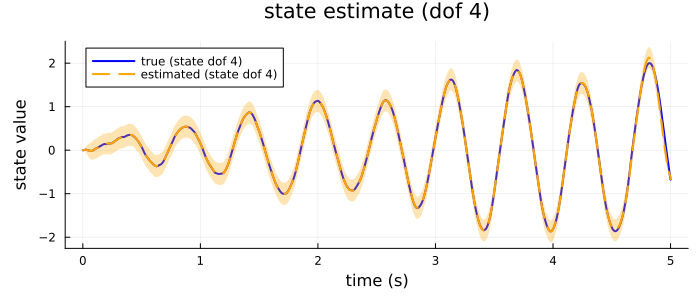

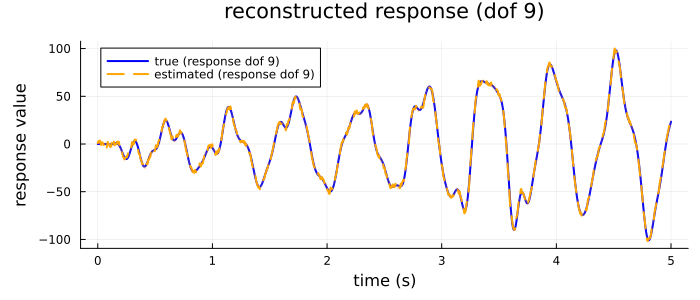

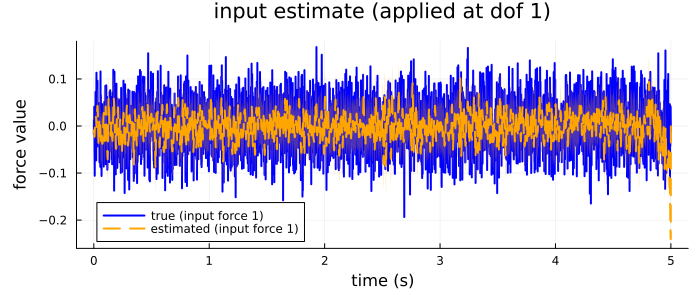

In [17]:
# select some DOFs to plot
ndof = size(StructuralModel.M)[1]

display_state_dof = 4                # dof 1:4 displacements, dof 5:8 velocities
display_response_dof = 2 * ndof + 1       # dof 1:4 displacements, dof 5:8 velocities, dof 9:12 accelerations
display_input_dof = 1                # the only one really

# plot the states
state_plot = plot_with_uncertainty(
    model_data.t,
    model_data.x_real[display_state_dof, :],
    getindex.(mean.(smoother_results.state_marginals), display_state_dof),
    getindex.(std.(smoother_results.state_marginals), display_state_dof),
    "state value",
    "state estimate (dof $(display_state_dof))",
    "state dof $(display_state_dof)"
);

# plot the responses
response_plot = plot_with_uncertainty(
    model_data.t,
    model_data.y_real[display_response_dof, :],
    getindex.(smoother_results.y_full_means, display_response_dof),
    getindex.(smoother_results.y_full_stds, display_response_dof),
    "response value",
    "reconstructed response (dof $(display_response_dof))",
    "response dof $(display_response_dof)"
);

# plot the inputs
input_plot = plot_with_uncertainty(
    model_data.t,
    model_data.p_real[:, display_input_dof],
    smoother_results.p_means,
    smoother_results.p_stds,
    "force value",
    "input estimate (applied at dof $(display_input_dof))",
    "input force $(display_input_dof)"
);

display(state_plot)
display(response_plot)
display(input_plot)


Let's quickly go over these results now:
1. State estimation: The **true state** and the **estimated state** show excellent agreement, demonstrating the accuracy of the smoother model implemented via `RxInfer`. The **uncertainty bounds** around the estimated states are noticeable, especially early in the domain. This reflects the natural uncertainty in state estimation since only **accelerations** are observed, whereas displacements and velocities are inferred through integration.
2. Reconstructed response: the **real response** and the **reconstructed response** align well across the domain, confirming that the filter captures the dynamics quite nicely. The uncertainty bounds here are narrower, showing that the confidence improves as the filter incorporates observations of these quantities of interest (i.e. accelerations).
3. Input force reconstruction: The **input force** and its **reconstructed counterpart** show significant high frequency variations with very narrow uncertainty bounds. This is expected because accelerations, being the directly observed quantities, are estimated with higher confidence. Plus, we gave ourselves a small advantage by using a well-calibrated prior on this quantity of interest ($Q_p$).

The results demonstrate how well the smoother model, implemented with RxInfer, performs in capturing the system dynamics and reconstructing hidden states and inputs. Notably, setting up the probabilistic model was straightforward and intuitive—much easier than dealing with the rest of the structural modeling! This highlights the power of RxInfer for quickly building and solving complex inference problems while keeping the implementation clean and efficient.

With just a few lines of code, we were able to estimate states, reconstruct responses, and confidently quantify uncertainties—a win for both accuracy and usability. 🚀